In [1]:
from cleandata import *  # analysis:ignore
import pandas as pd
from SVM import *  # analysis:ignore
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.mixture import BayesianGaussianMixture as BGM
from LSTM import *
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from cycler import cycler
from ML2020 import *
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


The goal for this project is to research different machine learning algorithms to apply in the field of finance. Our endpoint is a machine learning pipeline that uses historical data of 500 companies to construct a portfolio of 15 stocks that the algorithm predicts will generate best returns. This portfolio is balanced monthly and backtested over a period of 12 months. While these were the goals from the academic and theoretical perspective, our actual goals were dictated by Prof. Kon early in the project.
Prof. Kon encouraged us to explore different algorithms and think out of the box with the set of features we had. The goal was to optimize team effort by sharing our problems and solutions with the team, thus creating a single unit that worked in sync. Our vision for this pipeline was for it to be automated and modular – we wanted the pipeline to be self-sufficient once it received its desired parameters but also flexible enough to replace one function with another without any hinderance.

# 1.Data Scraching and Processing

## 1.1 Data from WRDS

Scatching S&P500 fundamental monthly data from WRDS(Wharton Research Data Services), 'Compustat' database by SAS. The date of the role dataset is from 1/1/2013 to 6/5/2020. The number of companies included in the dataset is more than 3000 from 2014/9 to 2019/9. And number of companies is less than 500 before 2014/9 and after 2019/10. The role dataset contains 309 variables and 25937 entries. 

## 1.2 Data from Yahoo Finance
- Step1: Load in companies table from 1.2
- Step2: from pandas_datareader import data, and use data.get_data_yahoo method to scrape monthly open, close, high, low, volume data of companies in the table using 'co_tic' (ticker) variable from the table from 8/31/2013 to 1/31/2020 (time span is defined by user)
- Step3: import all technical indicator construction methods from TA-lib; load in company monthly data from step 2 and construct all technical indicators using ta_indicators function, in which all TA-lib technicals are included
- Step4: return technicals to a table, technicals in columns, company at a time in rows


## 1.3 Merge fundamentals and technicals
- Use 'gvkey' and 'DATE' variables in both fundamental and technical tables to merge the two
- Lag return data, so that each row has 1-month lagged return

## 1.4 Processing the data --- Median Algorithm

Because of a large number of missing value in the dataset, the data was processed by the median algorithm:\

* Step1: Calculate the percentage of missing data in each columns.\
* Step2: Delete the columns with more than 30 percent missing data, 103 out of 309 variables were deleted.\
* Step3: Fill in each columns with median values.\
* Step4: To deal with the low rank problem of the dataset, random noise $Z_{ij}$ were added to the whole dataset with $Z_{ij}\sim$ N(0,1)


In [2]:
raw_data = pd.read_csv("fun_tech_2013_median.csv")
raw_data.head()

,Unnamed: 0,permno,gvkey,fyear,sic2,spi,mve_f,bm,ep,cashpr,...,STOCHRSI_FASTD,STOCHRSI_FASTK,STOCH_SLOWD,STOCH_SLOWK,TRANGE,TYPPRICE,Volume,WCLPRICE,WILLR,lagClose
0,0,79411,28648,2012,42,-0.002863,6889.63530,0.163084,0.056538,11.502685,...,52.655606,55.05861,60.751473,61.081358,5.87,61.469999,55489800.0,61.56250,-35.50184,61.560001
1,1,11081,14489,2012,22,-0.002863,23011.12000,0.464123,0.103081,-1.509500,...,52.655606,55.05861,60.751473,61.081358,5.87,61.469999,55489800.0,61.56250,-35.50184,61.560001
2,2,16678,6502,2012,37,-0.002863,14237.80000,0.295481,0.105143,-3.578541,...,52.655606,55.05861,60.751473,61.081358,5.87,21.068333,132791600.0,21.15625,-35.50184,20.170000
3,3,18403,8446,2012,36,-0.002863,4458.36900,0.711247,-0.220933,-2.544765,...,52.655606,55.05861,60.751473,61.081358,5.87,61.469999,55489800.0,61.56250,-35.50184,61.560001
4,4,40539,11672,2012,39,-0.002863,32705.89236,0.112088,0.058298,11.704499,...,52.655606,55.05861,60.751473,61.081358,5.87,29.405000,126245200.0,29.65250,-35.50184,28.195000


## 1.5 Multicolinearity checking---Variance inflation factor(VIF)

In order to further dealing with the low rank problem of the dataset. The VIF of the independent variables of the dataset were calculated and compared with each other. Finally 7 more variables, SINH, j, AVGPRICE, COSH, ROCP, SINH, ROCR100 were deleted due to high VIF. 

In [3]:
ML_object = MLEngineer(raw_data, num_stocks=40,
                       trading_window = 12, algorithm='SVM', small_sample=False, pca =True)
ML_object.data_processing()

date format corrected
missing indicator variables deleted
continous variables containing infinity deleted
missing continuous variables filled in with mean


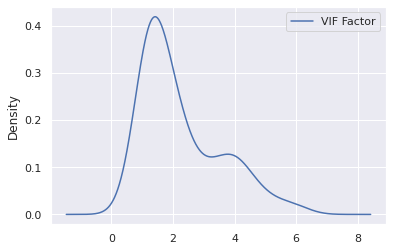

In [4]:
vif_df = ML_object.calc_vif()    
#vif_inf_flags = np.isinf(vif_df['VIF Factor'])
vif_inf_flags = vif_df['VIF Factor'] > 6
vif_df.loc[vif_inf_flags==False,:].plot.density()

In [5]:
ML_object.data_float.columns[vif_inf_flags]

Index(['mve_f', 'agr', 'acc', 'cf', 'currat', 'pchcurrat', 'quick', 'pchquick',
       'mve_ia', 'prc', 'mve_m', 'mve', 'pps', 'MEANEST', 'mom6m', 'chmom',
       'retvol', 'baspread', 'beta', 'betasq', 'rsq1', 'idiovol', 'ADD',
       'AROONDOWN', 'AROONOSC', 'AROONUP', 'ATAN', 'ATR', 'AVGPRICE',
       'BBANDS_LOWERBAND', 'BBANDS_MIDDLEBAND', 'BBANDS_UPPERBAND', 'CCI',
       'CMO', 'Close', 'High', 'LINEARREG', 'LINEARREG_INTERCEPT',
       'LINEARREG_SLOPE', 'LOG10', 'Low', 'MIDPOINT', 'MIDPRICE', 'MINUS_DM',
       'MOM', 'Open', 'PLUS_DM', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI',
       'SQRT', 'STDDEV', 'STOCHF_FASTD', 'STOCHF_FASTK', 'STOCHRSI_FASTD',
       'STOCHRSI_FASTK', 'STOCH_SLOWD', 'STOCH_SLOWK', 'TRANGE', 'TYPPRICE',
       'WCLPRICE', 'WILLR', 'lagClose'],
      dtype='object')

In [6]:
ML_object.clean_data = ML_object.clean_data.drop(ML_object.data_float.columns[vif_inf_flags], axis=1)

## 1.5 Valid Trading Period

Text(0, 0.5, '# Obs (# Company have data at time step)')

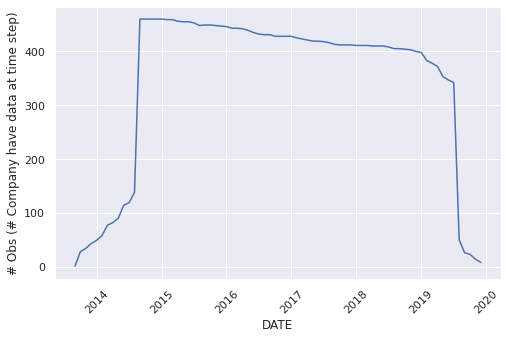

In [7]:
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(figsize=(8,5))
ax.xaxis.set_major_locator(loc)

#ax.plot(ML_object.date_list.strftime('%Y-%m'), ML_object.clean_data.groupby('DATE').count()['RET'].values)
ML_object.clean_data.groupby('DATE').count()['RET'].plot()
plt.xticks(rotation=45)
plt.ylabel('# Obs (# Company have data at time step)')

In our ML training, we focused on the time period between $\textbf{2015/09}\ and\ \textbf{2019/07}$,during which time, there is at least 400 companies at each month

# 2. Machine Learning Trading Framework

## 2.1 Time Step $T_i$

In our Machine Learning project, we conducted out of sample trading test based upon monthly window, at every timestep $T_i \in [2015/09, 2019/07]$, we constructed training dataset with $M$ months by looking back M months to timestep $T_i$, Thus for every $T_i$, there are roughtly $M*400 \approx 4800 (M=12)$ data points as the training dataset to predict the return on time $T_i$


In [8]:
time_step = pd.to_datetime('2015/09').to_period('M')
ML_object.split_date( time_step)[0]

,sic2,age,spii,woGW,sin,divi,divo,securedind,convind,rd,...,BETA,BOP,COS,LINEARREG_ANGLE,MFI,MINUS_DI,NATR,OBV,PLUS_DI,Volume
1293,52,1,1,0,0,0,0,1,0,0,...,-0.003996,0.305150,0.311784,0.084701,0.027372,-0.055628,-0.029759,0.430108,-0.079557,1.562245
1294,52,1,1,0,0,0,0,0,0,0,...,-0.003872,0.158028,-1.471912,0.084701,0.027372,-0.055628,-0.029759,4.544802,-0.079557,4.582742
1295,45,1,1,0,0,0,0,0,0,0,...,-0.004016,0.567050,1.348948,0.084701,0.027372,-0.055628,-0.029759,-0.233981,-0.079557,-0.360656
1296,59,1,1,0,0,0,0,0,0,0,...,-0.003631,0.356423,-1.289594,0.084701,0.027372,-0.055628,-0.029759,-0.157283,-0.079557,0.000744
1297,22,1,1,0,0,0,0,0,0,0,...,-0.003913,0.041615,0.006783,0.084701,0.027372,-0.055628,-0.029759,-0.157000,-0.079557,-0.262713
1298,23,1,0,0,0,0,0,0,0,0,...,-0.003913,0.041615,0.006783,0.084701,0.027372,-0.055628,-0.029759,-0.157000,-0.079557,-0.262713
1299,9,1,1,1,0,0,0,0,0,0,...,-0.003467,-0.977920,-1.482907,0.084701,0.027372,-0.055628,-0.029759,-0.070606,-0.079557,0.056911
1300,52,1,1,0,0,0,0,0,0,0,...,-0.004397,0.905552,-1.469653,0.084701,0.027372,-0.055628,-0.029759,-0.074947,-0.079557,-0.242282
1301,52,1,1,0,0,0,0,1,0,0,...,-0.004485,0.888484,1.283659,0.084701,0.027372,-0.055628,-0.029759,-0.160922,-0.079557,-0.339451
1302,9,1,1,0,0,0,0,0,0,0,...,-0.004101,-0.400191,-0.763076,0.084701,0.027372,-0.055628,-0.029759,1.167067,-0.079557,2.618517


## 2.2 Clustering on Time Step T_i

Based upon the 4800 companies'data at each time step $T_i$, we proceed with first clustering the training set with $\textbf{Bayesian Gassusian Mixture Model}$, which automatically cluster the data to maximum of 20 clusters of data. Then for each cluster of the data, our machine uses user specified ML algorithm to train from cluster to cluster

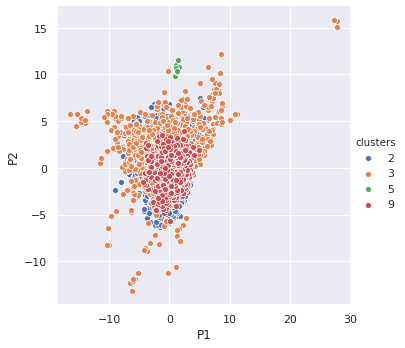

In [9]:
portfoli_permno, indx_rank = ML_object.opti_stocks(time_step)

The above plot visualize the clustering of $400*M$ data points using Principle Component Reduction, the whole dataframe with dimension of (4800 x 131) was reduced into (4800 x 2)  principle components and is then plotted with different color as their cluster

## 2.2 Portfolio On Time Step $T_i$

Then based upon the timestep $T_i$, we can use user-specified machine learning algorithm to predict the return on date $T_i$, and construct a portfolio consist of $K$ stocks based upon the prediction

In [10]:
print(portfoli_permno)

[37284 39917 39642 39538 40125 38156 38703 39490 38762 19561 87657 56573
 57568 77338 20626 28222 87267 58683 25582 10145 27043 27887 91392 86102
 62092 28388 53065 75186 77605 86111 12431 86339 12872 64390 44601 84129
 65330 77702 23579 43350]


## 2.3 Return along the whole trading period

As we move $T_i$ along the whole trading period of $2015/09$ to $2019/07$, we could construct a series of portfolios and analyze the returns, 
* At each time steps $T_i \in [2015/09, 2019/07]$,  we 
    * find the correspoding training set by looking back $M$ months
        * cluster the $M$ months data upto 20 clusters
            * Train our machine on cluster j
            * predict return on timestep $T_i$ that fall into cluster j
        * form portfolio consists of K stocks based upon the prediction
* Generate return plot for analysis        
            

In [11]:
time_list =['2018-09', '2019-07']
returns_long = ML_object.profit_construct(time_list, strategy ='long_equal_weighted')

2018-09
2018-10
2018-11
2018-12
2019-01
2019-02
2019-03
2019-04
2019-05
2019-06
2019-07


In our later algorithm research, we automated the whole Mahcine Learning framework into a onestep function taking necessary input parameters

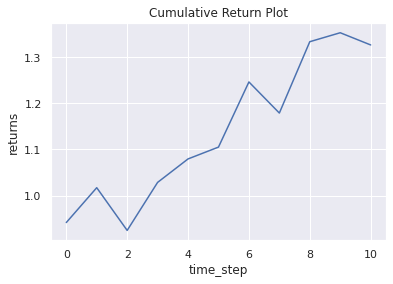

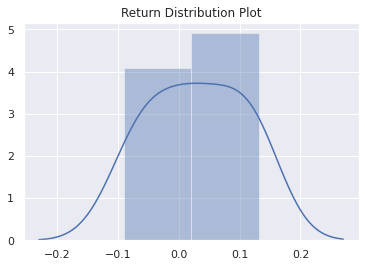

In [12]:
ML_object.return_plot(returns_long)

## 3. Machine Learning Algorithms 


During the summer, we mainly investigated SVM, Gradient Boosting, LSTM neural network and Kernel Regression, four algorihtms

## 3.1 SVM Machine

In our SVM machine, we used gaussian kernel to do return regression (SVR). SVR gives us the flexibility to define how much error is acceptable in our model and will find an appropriate line (or hyperplane in higher dimensions) to fit the data.

In contrast to OLS, the objective function of SVR is to minimize the coefficients — more specifically, the $L2$-norm of the coefficient vector — not the squared error. The error term is instead handled in the constraints, where we set the absolute error less than or equal to a specified margin, called the maximum error, $\epsilon$ (epsilon). We can tune epsilon to gain the desired accuracy of our model. Our new objective function and constraints are as follows:


$$min\ \frac{1}{2}||w||^2 + C\sum_{i=1}^n|\xi_i|$$
$$s.t\ |y_i - w_ix_i| \leq \epsilon + |\xi_i|$$

The hyperparameter tunning on C through a grid search is available with an optional parameter

date format corrected
missing indicator variables deleted
continous variables containing infinity deleted
missing continuous variables filled in with median
2015-09


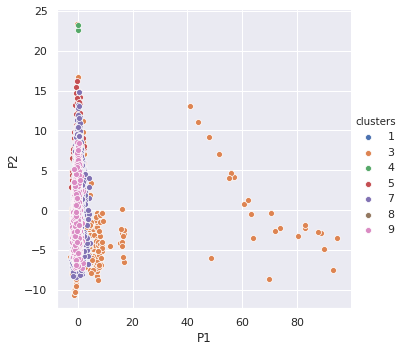

2015-10
2015-11
2015-12
2016-01
2016-02
2016-03
2016-04
2016-05
2016-06
2016-07
2016-08
2016-09


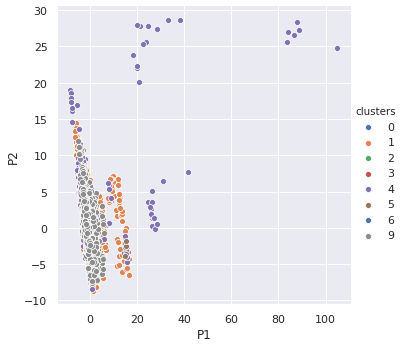

2016-10
2016-11
2016-12
2017-01
2017-02
2017-03
2017-04
2017-05
2017-06
2017-07
2017-08
2017-09


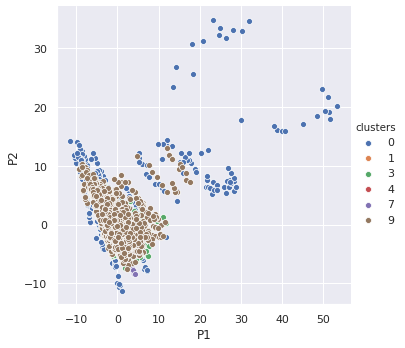

2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
2018-05
2018-06
2018-07
2018-08
2018-09


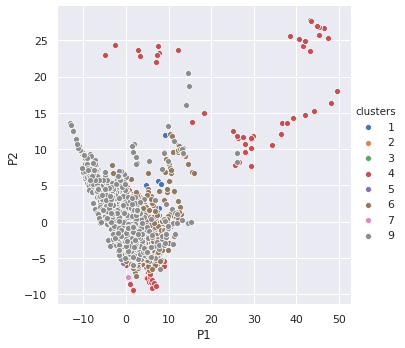

2018-10
2018-11
2018-12
2019-01
2019-02
2019-03
2019-04
2019-05
2019-06
2019-07


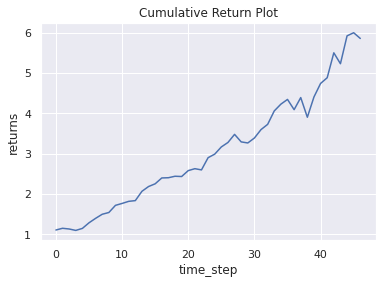

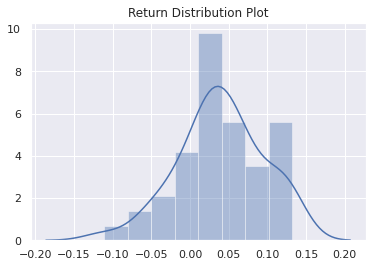

In [13]:
param_dict = {'num_stocks':40,
              'trading_window' : 12,
              'time_list' : ['2015-09-01', '2019-07-01'],
              'strategy' : 'long_equal_weighted',
              'algorithm': "SVM",
              'fill_in_method': 'median',
              'pca': True
}
ML_object = one_step_function(raw_data, param_dict)

## 3.2 LSTM Neural Network

In [14]:
from IPython.display import HTML
HTML('''<script>
var code_show_err = false; 
var code_toggle_err = function() {
 var stderrNodes = document.querySelectorAll('[data-mime-type="application/vnd.jupyter.stderr"]')
 var stderr = Array.from(stderrNodes)
 if (code_show_err){
     stderr.forEach(ele => ele.style.display = 'block');
 } else {
     stderr.forEach(ele => ele.style.display = 'none');
 }
 code_show_err = !code_show_err
} 
document.addEventListener('DOMContentLoaded', code_toggle_err);
</script>
To toggle on/off output_stderr, click <a onclick="javascript:code_toggle_err()">here</a>.''')

date format corrected
missing indicator variables deleted
continous variables containing infinity deleted
missing continuous variables filled in with median
2015-09


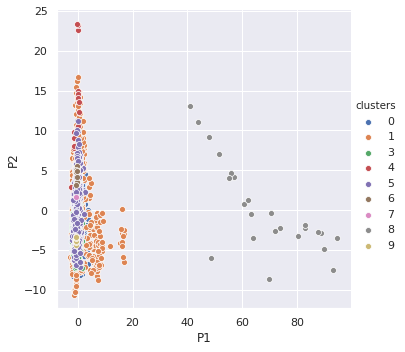

2015-10
2015-11
2015-12
2016-01
2016-02
2016-03
2016-04
2016-05
2016-06
2016-07
2016-08
2016-09


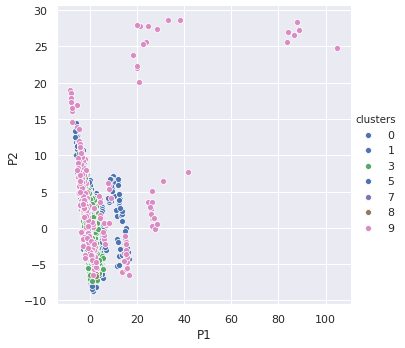

2016-10
2016-11
2016-12
2017-01
2017-02
2017-03
2017-04
2017-05
2017-06
2017-07
2017-08
2017-09


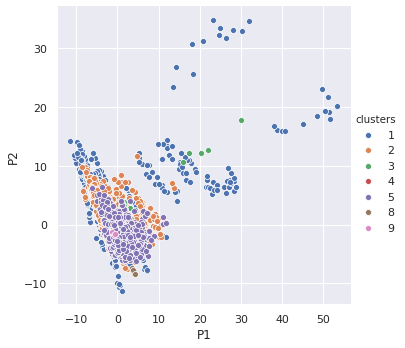

2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
2018-05
2018-06
2018-07
2018-08
2018-09


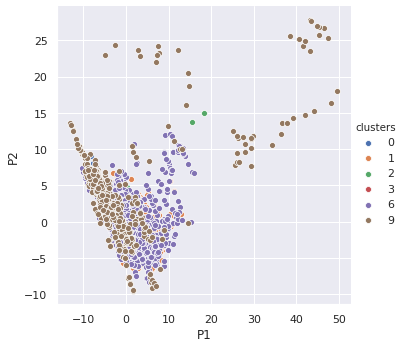

2018-10
2018-11
2018-12
2019-01
2019-02
2019-03
2019-04
2019-05
2019-06
2019-07


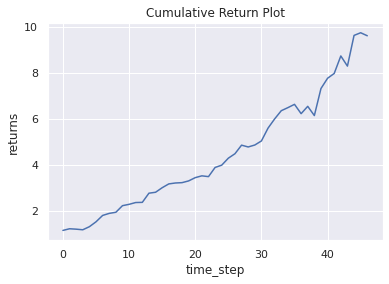

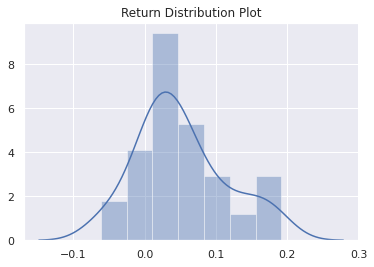

In [15]:
param_dict ['algorithm'] = 'LSTM'
ML_object = one_step_function(raw_data, param_dict)

## 3.3 Gradient Boosting


### 3.3.1 Introduction

In general, the boosting algorithm is a method to iteratively enhance the performance of many weak learners by merging them together, and if we adopt a decision tree regression as the basic learner, we would have a gradient boosting tree regressor. Consider the training data $\mathcal{T}=\{(x_i, y_i)\}_{i=1,...,n}$, with the input $x_i=(x_{1i}, x_{2i},...,x_{ki})$ and the output $y_i$, that is, we have $n$ observations, and for each observation, there are $k$ features and 1 response. Then, we will split the features of our training dataset sequentially based on regression tree, and perform multiple regressions in different regions to train the machine, and therefore we can use this trained machine to do further prediction if we have testing features. Computationally, we can use the forward stagewise additive modeling(FSAM), whose main algorithm is to keep updating the values in each new split region as we increase the number of splits, and add the trees together to form the machine. In this report, we will use the method introduced above to predict the future returns of the SP500 stocks, and build portfolios accordingly.

#### Gradient Boosting Regression Tree and FSAM}
GBRT regressor are additive models whose prediction $\hat{y_i}$ for a give input $x_i$ is of the following form:
\begin{equation*}
    \hat{y_i}=F_M(x_i)=\sum_{m=1}^M T_m(x_i)
\end{equation*}
where $T$ is a simple decision tree regressor, and hence
\begin{equation*}
    F_m(x)=F_{m-1}(x) + T_m(x)
\end{equation*}
where the newly added tree $T_m$ is fitted to minimize a sum of losses $L_m$, given the previous ensemble $F_{m-1}$:
\begin{equation*}
    T_m=\text{arg}\underset{T}{\text{min}}L_m=\text{arg}\underset{T}{\text{min}}\sum_{i=1}^n l(y_i,F_{m-1}(x_i)+T(x_i)),
\end{equation*}
where $l$ is a differentiable loss function. And if we perform a first order Taylor expansion to $L_m$ around $F_{m-1}(x_i)+T(x_i)$, the value of the loss can be estimated as follows:
\begin{equation*}
    l(y_i,F_{m-1}(x_i)+T(x_i))\approx l(y_i,F_{m-1}(x_i)) + T_m(x_i)\left[\frac{\partial l(y_i,F(x_i))}{\partial F(x_i)}\right]_{F=F_{m-1}}
\end{equation*}
After removing the terms that do not include $T$, we can approximate each decision tree regressor in the following way:
\begin{equation*}
    T_m\approx\text{arg}\underset{T}{\text{min}}\sum_{i=1}^n T(x_i)\left[\frac{\partial l(y_i,F(x_i))}{\partial F(x_i)}\right]_{F=F_{m-1}}
\end{equation*}
\\
To elaborate the details of GBRT machine, let's consider the GBRT regressor with squared error loss
\begin{equation*}
    L(y,f(x))=(y-f(x))^2
\end{equation*}
and the number of weak learners is $M$, and hence we will split the features into M regions.
\\
The prediction rule is
\begin{equation*}
    f(x;\beta)=\sum_{m=1}^{M}T(x;\beta_m)
\end{equation*}
where $\beta=(\beta_1,...,\beta_M)$, $T(x;\beta_m)$ is a stump with parameters $\beta=(R,\gamma), R=(j,c)$. $j$ is the index of a feature, and $c$ is the value at the knot of a feature, so $j$ and $c$ can help us determine the split. For instance,
    $$R_1(j,c)=(x:x_j\leq c)$$
    $$R_2(j,c)=(x:x_j> c)$$

And hence $R$ indicates our choice of split, with number of splits $M$, and $\gamma$ is the estimated value in each region. Since each weak learner is a decision tree regression, $\hat{\gamma}$ would be the mean in that region. We then adopt the FSAM algorithm which is built in a greedy fashion to fit the model. In FSAM, as we increase the number of splits, in each 
region we add, we fit the newly added tree in order to minimize the total loss, and we will use the fitted value in each region. Mathematically speaking, for $m=1,...,M$, $\hat{\beta}_m = \text{arg}\underset{\beta}{\text{min}}\sum_{i=1}^{N}L(y_i,f_{m-1}(x_i)+T(x_i;\beta))$. The summary of FSAM algorithm is as following:

<img src="img/algo.png" width=2000 height=100 />


### 3.3.2 Dataset 
The dataset we used was scrapped from Wharton Research Data Services(WRDS) and Yahoo Finance, and it consists of the monthly data of the companies in SP500 from January 2014 to December 2019. The response is the monthly return(RET) of each stock and the features are the corresponding technical and fundamental indicators. The features include categorical and numerical data. Some columns in the dataset include missing values. We would split the dataset into training set(January 2014 to December 2018) and testing set(January 2019 to December 2019). After training the machine using the training set, we will use the features in testing set to predict the returns in 2019 and build the portfolio accordingly, and finally compare with the true return to evaluate the portfolio. 

### 3.3.3 Machine Setup
In this section, we would briefly summarize how we built up our machine. We used the built-in function "GradientBoostingRegressor" found in the package of "scikit learn" in python to perform the regression. 

\subsection{Data Cleaning and Features Selection}
We dropped all the categorical features in the dataset, because the regressor needs to split the features at some knots (i.e. $x_j>c$ and $x_j\leq c$), but categorical data cannot be divided into two halves at the knots.
\\
Despite the fact that we came up with some ways (either using the median or randomly generalizing some numbers around a specific value) to fill up the missing values in the original dataset, we still decided to drop all the observations with missing values in any of the numerical features. A decision tree would split the features at the knots
to minimize the total losses. If we filled the missing values with the medians or with some close numbers, we would end up with the features with a lot of repeat or close values. Thus, in order to minimize the loss, the decision tree would very likely to split the features right at the knots that we filled in. Namely, we determine the choice of split which is supposed to be determined by the data.

### 3.3.4 Modeling
We decided to look back one month, that is, to train the machine we would regress the return of the stock price of a company in the current month on the features of this company last month; to do the prediction on the next month, we would use the features this month.
\subsubsection{Machine training}
We use our regressor to regress the monthly return of each company from February 2014 to December 2018 on the features of the corresponding companies from January 2014 to November 2018. After the training is done, we then use features of each company from December 2018 to November 2019 to predict the corresponding returns from January 2019 to December 2019.
### 3.3.5 Parameters tuning
There are 4 basic parameters in the machine, i.e. n\_estimators, max\_depth, min\_samples\_split, learning\_rate. max\_depth and learning\_rate are the ones to be tuned.
<img src="img/tune.png" width=2000 height=100 />
max\_depth somehow controls the number of trees that we need to add in the machine, a small value of max\_depth leads to underfit while a large value may lead to overfit.
learning\_rate can be regarded as the step size when minimizing the loss. A small value of learning\_rate could cause a very slow convergence or being trapped in a local minimum, while a large value could lead to jumping over around the global minimum.
\\
There are three ways to tune these two parameters:

(1) Create a 2-dimensional grid of the values of these two parameters. For each pair of the values, calculate the corresponding sum squared errors, and choose the pair with the smallest error. However, this method is computationally expensive and may take a lot of time to run the program;

(2) Initialize the values of these two parameters as 0. Fix the first parameter, and minimize the sum square errors over the values of the second parameter and update its value; and then fix the second parameter and update the first one. Iterate the above steps until convergence. This method takes shorter time to run but it could lead to a local minimum of the total loss;

(3) Follow the skeleton of the previous methods, but randomly select the initial values of the parameters, and perform the optimization multiple times. This would slightly increase the running time but would decrease the possibility to be trapped in local minimum.


### 3.3.6 Result Plot
After model is trained, the machine will use data from 2018 till 2019 as test set to apply reality check, portfolios of machine performance will also be generated.
One year prediction is made for each company with sufficient data and cumulative returns are generated for both predictions and actual values. 

Comparison plots for top return companies were generated for more detailed examination.

<img src="img/Capturefour.PNG" width=800 height=80 />

Examining the plots we see that the machine is capable of capturing the brief trend line of company returns, but is not always accurate in prediction of final results. Only half of the companies in pictures has correct prediction direction of returns.  
\\
Plots for least return companies were also generated.


<img src="img/Capturefour2.PNG" width=800 height=80 />

\\Viewing the plots, similar conclusions can be drawn that the model captures some directional movement for returns but fails in recognizing larger turns that may affect the overall cumulative result. 


## 3.4 Kernel Regression

Kernel ridge regression (KRR) combines Ridge regression and classification (linear least squares with l2-norm regularization) with the kernel trick. It thus learns a linear function in the space induced by the respective kernel and the data. For non-linear kernels, this corresponds to a non-linear function in the original space.

KRR is similar to the support vector regression (SVR). However, different loss functions are used: KRR uses squared error loss while SVR uses insensitive loss, both combined with l2 regularization. In contrast to SVR, fitting KernelRidge can be done in closed-form and is typically faster for medium-sized datasets. On the other hand, the learned model is non-sparse and thus slower than SVR, which learns a sparse model for $\epsilon>0$ , at prediction-time

# 4. Reality Check --- Random Portfolio

Since we would be implementing the stock selection model to S&P 500 universe after year 2013, we first downloaded all historical constituents from S&P 500 and found those after year 2013. Then we used the constituents to find and download fundamental data of these companies. After that we constructed fundamental signals following instructions in the paper Leon recommended.

Though at this moment we had sufficient data to train a model, we would like to plug in technical data as well. Later, we may conduct a study between the difference of technical and fundamental’s efficacy to predict stock returns. For the moment, we scrapped ‘high’, ‘low’, ‘open’, ‘close’ and ‘volume’ data from Yahoo Finance and constructed all technical listed in TA-Lib by plugging in the data to all the technical functions. 

By then we had a dataset consisting of fundamentals as well as technicals, and we were ready to train the prediction model and used the prediction results to work on stock selection.

We trained and tested several models. One of them is the LSTM model. The model is particularly good at dealing with time series data. The testing results was really good, with an average annual return of more than 40% over the period between 2013 and 2019.

We constructed a long-only dummy portfolio for comparison. In this portfolio, we longed random 20% of stocks from S&P 500 at a time. The return plot and distribution are shown below. The trend looks very similar to the S&P 500 index movement, which went through one of the strongest bull market in the period we have been training model.

<img src="img/rp_cret.png" width=500 height=80 />

<img src="img/rp_dist.png" width=500 height=80 />
